# Variational Autoencoder on MNIST

This notebook demonstrates:
- Loading MNIST from CSV
- Binarizing the images
- Training a Variational Autoencoder (VAE)
- Testing test data


In [ ]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.Collecting torch
  Using cached torch-2.10.0-cp312-cp312-win_amd64.whl.metadata (31 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB 388.9 kB/s eta 0:04:53
   ---------------------------------------- 0.1/113.8 MB 491.5 kB/s eta 0:03:52
   ---------------------------------------- 0.1/113.8 MB 717.5 kB/s eta 0:02:39
   ---------------------------------------- 0.2/113.8 MB 841.6 kB/s eta 0:02:15
   ---------------------------------------- 0.3/113.8 MB 1.2 MB/s eta 0:01:39
   ---------------------------------------- 0.5/113.8 MB 1.4 MB/s eta 0:01:19
   ---------------------------------------- 0.6/113.8 MB 1.7 MB/s eta 0:01:07
   ---------------

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\Users\\DELL\\anaconda3\\Lib\\site-packages\\torch\\distributions\\mixture_same_family.py'
Consider using the `--user` option or check the permissions.



   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB 325.1 kB/s eta 0:05:50
   ---------------------------------------- 0.0/113.8 MB 279.3 kB/s eta 0:06:48
   ---------------------------------------- 0.1/113.8 MB 381.3 kB/s eta 0:04:59
   ---------------------------------------- 0.1/113.8 MB 403.5 kB/s eta 0:04:42
   ---------------------------------------- 0.1/113.8 MB 399.4 kB/s eta 0:04:45
   ---------------------------------------- 0.1/113.8 MB 399.4 kB/s eta 0:04:45
   ---------------------------------------- 0.2/113.8 MB 426.7 kB/s eta 0:04:27
   ---------------------------------------- 0.2/113.8 MB 452.9 kB/s eta 0:04:11
   ---------------------------------------- 0.2/113.8 MB 429.5 kB/s eta 0:04:25
   ---------------------------------------- 0.2/113.8 MB 429.5 kB/s

In [1]:
# Imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Load & Binarize Data
class MNISTCSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)

        self.labels = df.iloc[:, 0].values
        images = df.iloc[:, 1:].values / 255.0
        images = (images > 0.5).astype("float32")

        self.images = torch.tensor(images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [3]:
train_dataset = MNISTCSVDataset("data/mnist_train.csv")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [4]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# Training
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dataset):.4f}")

Epoch 1, Loss: 156.8836
Epoch 2, Loss: 108.3834
Epoch 3, Loss: 99.7287
Epoch 4, Loss: 95.7940
Epoch 5, Loss: 93.4526
Epoch 6, Loss: 91.7433
Epoch 7, Loss: 90.5036
Epoch 8, Loss: 89.5894
Epoch 9, Loss: 88.8082
Epoch 10, Loss: 88.1272


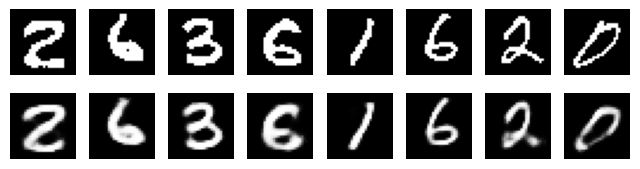

In [8]:
x, _ = next(iter(train_loader))
x = x.to(device)
recon_x, _, _ = model(x)

plt.figure(figsize=(8,2))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x[i].view(28,28).cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_x[i].view(28,28).detach().cpu(), cmap="gray")
    plt.axis("off")
plt.show()

# TEST DATA


In [9]:
test_dataset = MNISTCSVDataset("data/mnist_test.csv")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
model.eval()  

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [13]:
test_loss = 0
with torch.no_grad():  
    for x, _ in test_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        test_loss += loss.item()

print(f"Average Test Loss: {test_loss/len(test_dataset):.4f}")

Average Test Loss: 87.9738


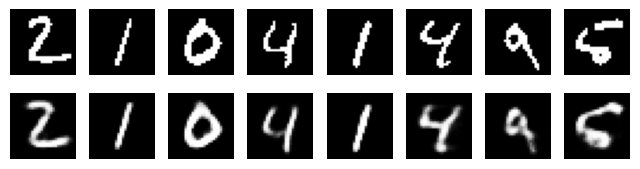

In [ ]:
import matplotlib.pyplot as plt

x, _ = next(iter(test_loader))
x = x.to(device)
recon_x, _, _ = model(x)

plt.figure(figsize=(8,2))
for i in range(8):

    plt.subplot(2,8,i+1)
    plt.imshow(x[i].view(28,28).cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_x[i].view(28,28).detach().cpu(), cmap="gray")
    plt.axis("off")

plt.show()